# Time-series prediction of renewable energy production

* Use 2017 for training and 2018 for testing.
* Problem framing: predict renewable energy ratio at time t based on weather forecast for time t+1.
  * For training, this means shifting weather features back one time step.


In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from scipy.signal import savgol_filter

Using TensorFlow backend.
/home/johannes/.virtualenvs/renewables_notebooks/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)
# Ignore warning
pd.options.mode.chained_assignment = None

In [4]:
generation_data = pd.read_csv('../data/generation_2017.csv').set_index('timestamp')
environment_data = pd.read_csv('../data/environment_2017.csv').set_index('timestamp')
training_data = pd.concat([generation_data, environment_data], axis=1)

In [5]:
def shift_weather_features_back(data, n):
    """
    Shift weather observations back in time. The weather observation at time t can then be interpreted
    as a forecast made at time t.
    """
    shifted = data.copy()
    shifted.wind_speed = shifted.wind_speed.shift(-n)
    shifted.temperature = shifted.temperature.shift(-n)
    shifted.cloud_cover = shifted.cloud_cover.shift(-n)
    shifted.pressure = shifted.pressure.shift(-n)
    shifted = shifted[:-n]
    return shifted


In [6]:
def _split_train_test(ds, ratio=2/3):
    """
    Utility method for splitting a dataset into training and testing sets.
    """
    train_length = int(ratio * len(ds))
    return ds[:train_length], ds[train_length:]


def _create_lookback_datasets(ds, lookback=1):
    """
    Create two datasets for training or validation: X = input, Y = output.
    X is three-dimensional: num_samples, lookback_range, num_features.
    Y is two-dimensional: num_samples, num_features. 
    The lookback argument tells us how many samples to scan back.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)


def create_datasets(data, lookback=6, scaler=MinMaxScaler(feature_range=(0, 1))):
    """
    Create X and Y datasets, where X is the lookback input and Y the output.
    """
    # select the columns to use for training
    df = data[['sun', 'wind_speed', 'cloud_cover', 'temperature', 'pressure']]

    # the ratio is what we want to predict
    df['ratio'] = data['renewables'] / (data['renewables'] + data['non_renewables'])
    df = df.reindex(columns=sorted(df.columns))
    df = df.reindex(columns=(['ratio'] + list([a for a in df.columns if a != 'ratio']) ))

    dataset = df.as_matrix()
    dataset = scaler.fit_transform(dataset)

    x, y = _create_lookback_datasets(dataset, lookback)

    # output: only the ratio (first column)
    y = y[:, 0:1]
    
    return x, y, df.shape[1], scaler

In [7]:
training_data_shifted = shift_weather_features_back(training_data, 1)
lookback = 12
train_x, train_y, num_features, scaler = create_datasets(training_data_shifted, lookback)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(lookback, num_features)))
model.add(Dense(1))
#model.add(LSTM(128, return_sequences=True, input_shape=(lookback, num_features)))
#model.add(Dropout(0.25))
#model.add(LSTM(128))
#model.add(Dense(num_features))
model.compile(loss='mae', optimizer='adam')
model.summary()
model.fit(train_x, train_y, epochs=70, batch_size=16, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
 - 12s - loss: 0.0511
Epoch 2/70
 - 11s - loss: 0.0269
Epoch 3/70
 - 11s - loss: 0.0227
Epoch 4/70
 - 14s - loss: 0.0220
Epoch 5/70
 - 15s - loss: 0.0217
Epoch 6/70
 - 16s - loss: 0.0217
Epoch 7/70
 - 15s - loss: 0.0212
Epoch 8/70
 - 15s - loss: 0.0212
Epoch 9/70
 - 15s - loss: 0.0213
Epoch 10/70
 - 16s - loss: 0.0209
Epoch 11/70
 - 15s - loss: 0.0208
Epoch 12/70
 - 17s - loss: 0.0210
Epoch 13/70
 - 15s - loss: 0.0206
Epoch 14/70
 - 15s - loss: 0.0205
Epoch 15/70
 - 10s - loss: 0.0201
Epoch 16/70
 - 15s - loss: 0.0201

In [15]:
train_score = model.evaluate(train_x, train_y, verbose=0)
print(f'Train Score: {train_score:.2} MSE ({math.sqrt(train_score):.2} RMSE)')

Train Score: 0.018 MSE (0.13 RMSE)


In [16]:
def plot_comparison(model, x, y, start=0, end=200):
    predict = model.predict(x)
    predict = list(itertools.chain.from_iterable(predict))
    plt.plot(y[start:end])
    #plt.plot(savgol_filter(predict[start:end], 3, 1))
    plt.plot(predict[start:end])
    plt.show()

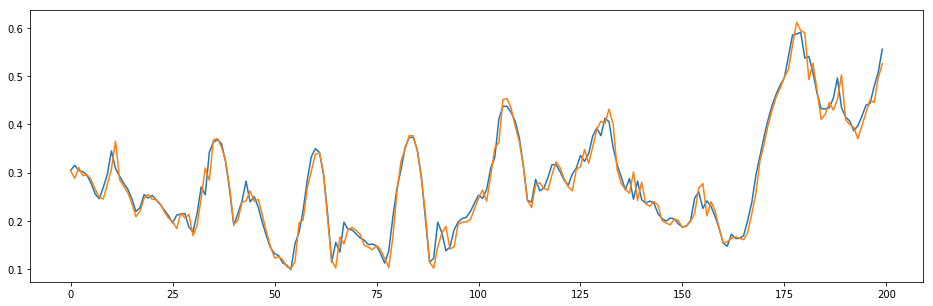

In [17]:
plot_comparison(model, train_x, train_y, start=1000, end=1200)

### Test with 2018 data

In [18]:
generation_data = pd.read_csv('../data/generation_2018.csv').set_index('timestamp')
environment_data = pd.read_csv('../data/environment_2018.csv').set_index('timestamp')
test_data = pd.concat([generation_data, environment_data], axis=1)

test_data_shifted = shift_weather_features_back(test_data, 1)
test_x, test_y, _, _ = create_datasets(test_data_shifted, lookback, scaler)

In [19]:
test_score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Score: {test_score:.2} MSE ({math.sqrt(test_score):.2} RMSE)')

Test Score: 0.025 MSE (0.16 RMSE)


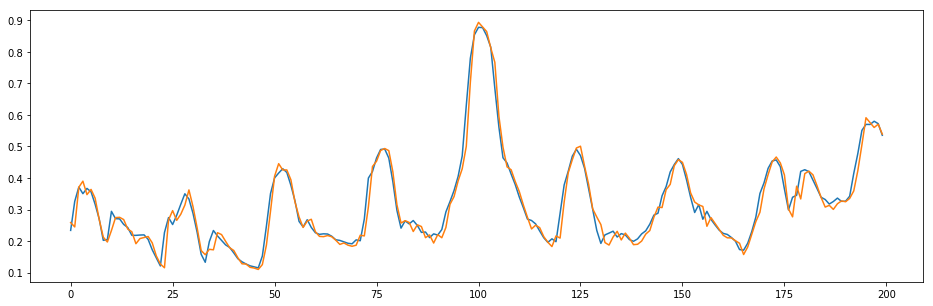

In [20]:
plot_comparison(model, test_x, test_y, start=1200, end=1400)

## Real-time predictions based on model constructed above

- six hours into the future
- same problem framing: weather features at time t are forecasts for t+1
- do this in app code and not here

In [3]:
model = load_model('model_lstm_128.h5')

In [21]:
def extend_prediction(model, x, t=1):
    """Returns X suitable for predicting t+1"""
    rows, lookback, _ = x.shape
    assert t < lookback, "Resulting X must retain at least one non-predicted value"
    x_t = x.copy()
    roll_one = lambda arr: np.roll(arr, -1, axis=1)
    for i in range(1, t + 1):
        p = model.predict(x_t)
        x_t = roll_one(x_t)
        for row in range(rows):
            x_t[row, 2] = p[row]
    return model.predict(x_t)

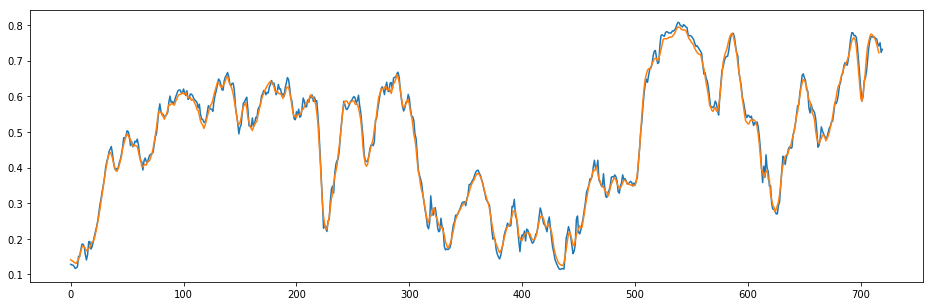

In [23]:
test_predict_t3 = extend_prediction(model, test_x, t = 2)
test_predict_t3_mw = scaler.inverse_transform(test_predict_t3)
test_predict_t3_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict_t3_mw]

plt.plot(real['ratio'])
plt.plot(savgol_filter(test_predict_t3_ratio[-717:], lookback, 1))
plt.show()

* with a lookback of 5, t+3 prediction is still possible
* filter reduces jitter

In [23]:
model.save('model_lstm_128.h5')

### References

* https://keras.io/getting-started/sequential-model-guide/
* https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
